# Data Bootcamp Final Project: State Gun Regulations and Violent Crimes
<br>
<br>

<div class="inline-block"> <img src="https://upload.wikimedia.org/wikipedia/commons/4/47/No_guns.svg" style="width: 250px;"/> </div> 

**Author: Daniel Herrera**

**Email: [dh2412@nyu.edu](dh2412@nyu.edu)**

The current national climate on guns and gun regulations has inspired me to look into the real effects of guns on safety. In this project I will show how lax gun regulations have a negative impact on personal safety. To do this I will specifically look at homicide and rape in states with poor gun control regulations versus states with more effective gun control regulations.
<br>
<br>
<br>

This project will be organized in several steps:
1. Desription of the data 
2. Discussion of the packages I use to perform the analysis
3. A map that shows the efficiency of gun regualtions accross states
4. Organization and presentation of the Data

## Data Report

There are two key sources of data for this project. The key data component to this project is the ratings of states' gun control regulation done by the [Giffords Law Center to Prevent Gun Violence](http://lawcenter.giffords.org). The Giffords Center provided the data under the condition that it not be published. For this reason and for the purpose of this report the data will be read in locally from my computer.

This project will also take data from the [FBI Crime Data API](https://crime-data-explorer.fr.cloud.gov/api) where as many as 18,000 law enforcement agencies in the US cooperate to provide these data and promote transparency in the judicial system( [FBI Crime Data Explorer](https://crime-data-explorer.fr.cloud.gov)).

## Packages

I will use the following packages to help me import and analyze my data:
- `pandas` is the key tool to import and manipulate the data
- `requests` and `json` are needed to import data from the FBI's API
- `matplotlib` enables me to plot charts and graphs
- `os` needed to import the map shapefile
- `fiona` is required
- `geopandas` creates a dataframe with shapes to make maps
- `shapely` creates and displays the shapes

In [1]:
import pandas as pd
import requests
import json
import matplotlib.pyplot as plt

import os
import fiona
import geopandas as gpd
from shapely.geometry import Point, Polygon

## Importing and Organizing the Data
Below I import both daatasets; the FBI API from the web, and the Giffords Center data I will read in from my computer due to the restrictions placed on the data. Here is a brief description of the data importing process:
- The FBI data has to be imported state by state, so I created a list of all the states using their 2 digit codes so that I may automate this process with a for loop. I also had to create an empty dataframe so that I could later append each state as it was being imported by the loop. Finally, I created a data frame with only the year and columns I was interested in called `crime2016`. To this dataframe I added two columns (`rapebypop` and `homicidebypop`). These are instances of each crime for every 100,000 people in the state. This is the dataframe I will use for my analysis.
- The Giffords Center data is read in from an excel file on my computer titled "yr2016". I only imported the columns and rows that were relevant to my analysis. Then I renamed a few of the columns and set the `Rank` column as the index for the dataframe.

In [2]:
state_list = ["AL","AK","AZ","AR","CA","CO","CT","DE","FL","GA","HI","ID","IL","IN","IA","KS","KY","LA","ME","MD",
              "MA","MI","MN","MS","MO","MT","NE","NV","NH","NJ","NM","NY","NC","ND","OH","OK","OR","PA","RI","SC",
              "SD","TN","TX","UT","VT","VA","WA","WV","WI","WY"]

In [3]:
df = pd.DataFrame(columns=['aggravated_assault', 'burglary', 'caveats', 'homicide', 'larceny',
       'motor_vehicle_theft', 'population', 'property_crime', 'rape_legacy',
       'rape_revised', 'robbery', 'state_abbr', 'violent_crime', 'year'])


df.shape # empty dataframe

(0, 14)

In [4]:
# If for some reason this doesn't work, you may need to
# go to the FBI API and get a new key
url1 = "https://api.usa.gov/crime/fbi/ucr/estimates/states/"
url2 = "?page=1&per_page=100&output=json&api_key="
key = "W4oJrpnslHJg0zJPFg8l1JK5udAqayXELjFyi2x0"

for state in state_list:
    url = url1 + state + url2 + key                # assembles the url
    response = requests.get(url)                   # calls the url
    crime = json.loads(response.content)           # loads the data into a dictionary
    df = df.append(pd.DataFrame(crime["results"])) # appends all the data into the empty df
df.shape

(1100, 14)

In [5]:
# Pulling out year 2016 and dropping unnecessary columns
crime2016 = df.loc[21].drop(columns=['aggravated_assault', 'burglary', 'caveats', 'larceny','motor_vehicle_theft', 
              'property_crime', 'rape_legacy', 'robbery', 'violent_crime', 'year'])

# Adding the rape/homicide per 100,000 population columns
crime2016['rapebypop'] = (crime2016.rape_revised / crime2016.population)*100000
crime2016['homicidebypop'] = (crime2016.homicide / crime2016.population)*100000
crime2016.head()

,homicide,population,rape_revised,state_abbr,rapebypop,homicidebypop
21,407,4863300,1385.0,AL,28.4786,8.3688
21,52,741894,757.0,AK,102.036,7.00909
21,380,6931071,2452.0,AZ,35.3769,5.48256
21,216,2988248,1545.0,AR,51.7025,7.22832
21,1930,39250017,10149.0,CA,25.8573,4.9172


In [6]:
# Reading in and organizing Giffords center data
yr2016 = pd.read_excel("2016_Chart.xlsx", skip_footer = 2, usecols = "A:B,AW")
yr2016 = yr2016.rename(columns={"Unnamed: 1":"NAME","Raw Score 2016":"Score"}).set_index("Rank") 
yr2016.head()

,NAME,Score
Rank,,
1,California,100.5
2,Connecticut,77.5
3,New Jersey,76.0
4,Massachusetts,71.5
5,Maryland,71.0


## Creating a Map: Showing which states have the strongest gun regulations
To create the map, I first read in a shapefile from my computer. Then I drop the territories and states not part of the continental United States. This is to make the map look nicer. Next, I merge the information about gun regulations scores which will help me color the map. Finally I create the map and add a legend.

In [7]:
cwd = os.getcwd()                                          # Getting my cwd
states_shape = cwd + "/shape_file/cb_2017_us_state_5m.shx" # Creating the path to the shapefile
us_map = gpd.read_file(states_shape)                       # Creating the geopandas dataframe
us_map.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,01,01779775,0400000US01,01,AL,Alabama,00,131174431216,4592944701,"(POLYGON ((-88.04374299999999 30.517423, -88.0..."
1,02,01785533,0400000US02,02,AK,Alaska,00,1478588231566,277723861311,"(POLYGON ((-150.242099 61.137835, -150.228774 ..."
2,04,01779777,0400000US04,04,AZ,Arizona,00,294198661567,1027245114,"POLYGON ((-114.799683 32.593621, -114.809393 3..."
3,08,01779779,0400000US08,08,CO,Colorado,00,268425964573,1178495763,"POLYGON ((-109.060253 38.599328, -109.059541 3..."
4,12,00294478,0400000US12,12,FL,Florida,00,138911437206,31398800291,"(POLYGON ((-80.751643 24.857254, -80.729063 24..."


In [8]:
# Dropping the states and territories that are out of the continental US
us_map = us_map.set_index("STUSPS").drop(["AK","HI","VI","PR","MP","AS","GU"])

In [9]:
# Merging with the gun regulation data
final_us_map = pd.merge(us_map, yr2016,on='NAME',how='right',indicator=True)
final_us_map.head()

,STATEFP,STATENS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry,Score,_merge
0,01,01779775,0400000US01,01,Alabama,00,1.311744e+11,4.592945e+09,"(POLYGON ((-88.04374299999999 30.517423, -88.0...",-1.5,both
1,04,01779777,0400000US04,04,Arizona,00,2.941987e+11,1.027245e+09,"POLYGON ((-114.799683 32.593621, -114.809393 3...",-11.0,both
2,08,01779779,0400000US08,08,Colorado,00,2.684260e+11,1.178496e+09,"POLYGON ((-109.060253 38.599328, -109.059541 3...",19.5,both
3,12,00294478,0400000US12,12,Florida,00,1.389114e+11,3.139880e+10,"(POLYGON ((-80.751643 24.857254, -80.729063 24...",3.5,both
4,13,01705317,0400000US13,13,Georgia,00,1.491775e+11,4.733386e+09,"POLYGON ((-85.605165 34.984678, -85.5525925734...",2.0,both


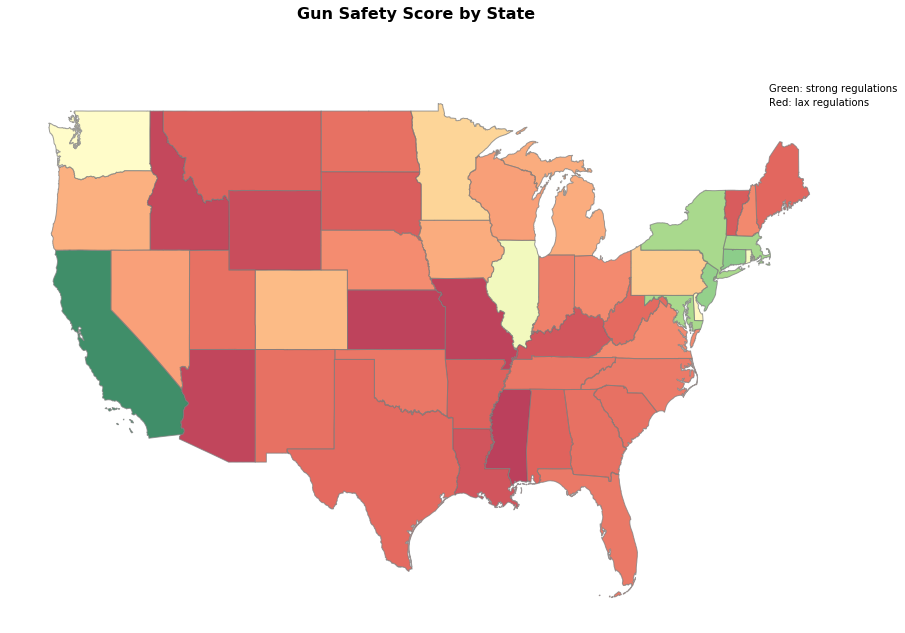

In [10]:
fig, ax = plt.subplots(figsize = (15,10))

# Creates the map and colors it according to regulation strength
final_us_map.plot(ax = ax, edgecolor='tab:grey',
             column='Score',
             cmap='RdYlGn',
             alpha = 0.75)

# Gets rid of the axes and spines
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# Adds a legend
message1 = "Green: strong regulations"
message2 = "Red: lax regulations"                                                
ax.text(-70,50,message1 )
ax.text(-70,49.3,message2)

# Chart Title
fig.suptitle("Gun Safety Score by State",
             fontsize = 16, fontweight = "bold")
plt.show()

## Visualizing the Relationship Between Gun Regulation and Crime
In this section I will create two graphs to show the relationship between gun regulations and crime.
- The first graph will show how some of the deadliest states have the more lax gun regulations while states with stronger gun regulations have lower homicide rates. 
- The second graph will show that states with higher gun safety scores experience less cases of rape than those with lower gun safety scores.

The procedure for making these graphs is similar. I will create lists to pull out of each dataframe (FBI and Giffords Center) the appropriate states for each graph and creae a new dataframe by merging the slices of each of the original dataframes. Then I will create two bar graphs that share a y-axis to show the relationship.

In [11]:
# Creating lists with the States I will use and their codes
homicide_statecodes = ["RI", "HI", "MN", "MA", "CT","NV", "MS", "AL", "MO", "LA"]
states = ["Rhode Island","Hawaii","Minnesota","Massachusetts","Connecticut","Nevada",
          "Mississippi","Alabama","Missouri","Louisiana"]
state_abbr = {"Rhode Island":"RI", "Hawaii":"HI" , "Minnesota":"MN", "Massachusetts":"MA", 
                      "Connecticut":"CT","Nevada":"NV", "Mississippi":"MS", "Alabama":"AL", 
                      "Missouri":"MO", "Louisiana":"LA"}

In [12]:
# Pulling out the states I want from the FBI dataframe
hom_cases = crime2016[crime2016.state_abbr.isin(homicide_statecodes)]
# Pulling out the same states from the Giffords dataframe
hom_gunreg = yr2016[yr2016.NAME.isin(states)]
# Adding the state codes to the Giffords dataframe
hom_gunreg["state_abbr"] = hom_gunreg['NAME'].map(state_abbr)

/Users/danielherrera/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [13]:
# Merging and Sorting the two dataframes
hom2016 = pd.merge(hom_cases, hom_gunreg, on='state_abbr',how='right',indicator=True)
hom2016.sort_values("homicidebypop", ascending = True, inplace = True)
hom2016.head()

,homicide,population,rape_revised,state_abbr,rapebypop,homicidebypop,NAME,Score,_merge
5,101,5519952,1731.0,MN,31.359,1.82973,Minnesota,26.5,both
4,134,6811779,1592.0,MA,23.3713,1.96718,Massachusetts,71.5,both
1,78,3576452,561.0,CT,15.6859,2.18093,Connecticut,77.5,both
2,35,1428557,447.0,HI,31.2903,2.45002,Hawaii,67.5,both
9,29,1056426,328.0,RI,31.0481,2.7451,Rhode Island,47.5,both


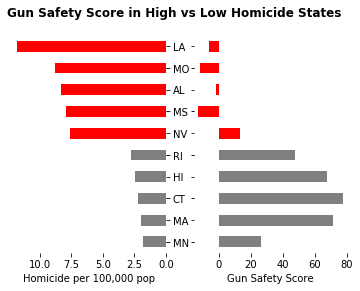

In [14]:
fig, axes = plt.subplots(ncols=2, sharey=True)

y = hom2016.state_abbr                          # Setting the y-axis

colors = ['gray','gray','gray','gray',          # Setting the colors
          'gray','r','r','r','r','r']

hom2016.homicidebypop.plot (kind="barh",        # Creating the left bar chart
                            ax=axes[0], 
                            color=colors)

hom2016.Score.plot (kind="barh",ax=axes[1],     # Creating the right bar chart
                    color=colors)

axes[0].set_xlabel('Homicide per 100,000 pop')   #Setting the X-Lables
axes[1].set_xlabel('Gun Safety Score')

axes[0].invert_xaxis()                          # Organizing the left bar chart
axes[0].set(yticklabels = hom2016.state_abbr)
axes[0].yaxis.tick_right()

for ax in axes.flat:                            # Setting the margins/removing spines
    ax.margins(0.03)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_visible(False)

                                                # Chart Title
fig.suptitle("Gun Safety Score in High vs Low Homicide States",
             fontsize = 12, fontweight = "bold")

fig.subplots_adjust(wspace=0.18)                # Setting the spacing          
plt.show()

In [15]:
best_worst_gunreg = ["California", "Connecticut", "New Jersey","Massachusetts","Maryland", "New York",
              "Idaho", "Arizona", "Kansas","Missouri", "Mississippi"]
state_abbr = {"California":"CA", "Connecticut":"CT", "New Jersey":"NJ", "Massachusetts":"MA", "Maryland":"MD",
              "New York":"NY","Idaho":"ID", "Arizona":"AZ", "Kansas":"KS","Missouri":"MO", "Mississippi":"MS"}
rape_statecodes = ["CA", "CT", "NJ", "MA", "MD","NY","ID", "AZ", "KS", "MO","MS"]

In [16]:
# Adding the state codes to the Giffords dataframe
rape_gunreg = yr2016[yr2016.NAME.isin(best_worst_gunreg)]
# Pulling out the same states from the Giffords dataframe
rape_gunreg["state_abbr"] = rape_gunreg['NAME'].map(state_abbr)
# Pulling out the states I want from the FBI dataframe
rape_cases = crime2016.loc[crime2016.state_abbr.isin(rape_statecodes)]


/Users/danielherrera/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [17]:
# Merging and Sorting the two dataframes
rape2016 = pd.merge(rape_gunreg, rape_cases, on='state_abbr',how='right',indicator=True)
rape2016.sort_values("Score", ascending = True, inplace = True)
rape2016.head()

,NAME,Score,state_abbr,homicide,population,rape_revised,rapebypop,homicidebypop,_merge
10,Mississippi,-13.0,MS,238,2988726,905.0,30.2805,7.96326,both
8,Kansas,-12.0,KS,111,2907289,971.0,33.3988,3.81799,both
9,Missouri,-12.0,MO,537,6093000,1884.0,30.9207,8.81339,both
7,Arizona,-11.0,AZ,380,6931071,2452.0,35.3769,5.48256,both
6,Idaho,-10.0,ID,49,1683140,529.0,31.4294,2.91123,both


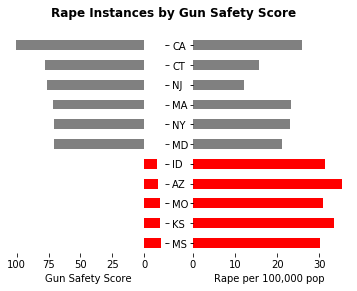

In [18]:
fig, axes = plt.subplots(ncols=2, sharey=True)

y = rape2016.state_abbr                           # Setting the y-axis

colors = ['r','r','r','r','r','gray',             # Setting the colors
          'gray','gray','gray','gray','gray']

rape2016.Score.plot (kind="barh", ax=axes[0],     # Creating the left bar chart
                     color=colors)
rape2016.rapebypop.plot (kind="barh", ax=axes[1], # Creating the right bar chart 
                         color=colors)

axes[0].set_xlabel('Gun Safety Score')            #Setting the x labels
axes[1].set_xlabel('Rape per 100,000 pop')

axes[0].invert_xaxis()                            # Organizing the left bar chart
axes[0].set(yticklabels = rape2016.state_abbr)
axes[0].yaxis.tick_right()

for ax in axes.flat:                              # Setting the margins/removing spines
    ax.margins(0.03)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_visible(False)

                                                  # Chart Title
fig.suptitle("Rape Instances by Gun Safety Score", 
             fontsize = 12, fontweight = "bold")  

fig.subplots_adjust(wspace=0.18)                  # Setting the spacing
plt.show()

## Summary: 
Based on this data it is fairly clear that there is still a long road ahead for the country with regards to effective gun regulation. However we can see the benefits of these efforts, the data show a relationship between strong gun regulations and a lower incidence of crime. While these relationships are not incredibly stong, I belive that with more future regulations the trend will continue in this direction and states with stronger regulations will experience less violent crimes.